SfN  2022 Poster
Layout and plot everything

In [47]:
import sys
import os
sys.path.append('/data/GitHub/NeuroPy')
sys.path.append('/data/GitHub/TraceFC/')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
%load_ext autoreload
%autoreload 2

import neuropy.io.miniscopeio as msio

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.io.minianio import MinianIO
from neuropy.core.ca_neurons import CaNeurons, CaNeuronReg, PairwiseMap, MultiSessionMap
from neuropy.plotting.ca_events import RasterGroup, Raster
from neuropy.plotting.figure import Fig, Colormap
import session_directory as sd
from traceio import load_trace_events
from imaging.rasters import plot_paired_CS_PETH

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


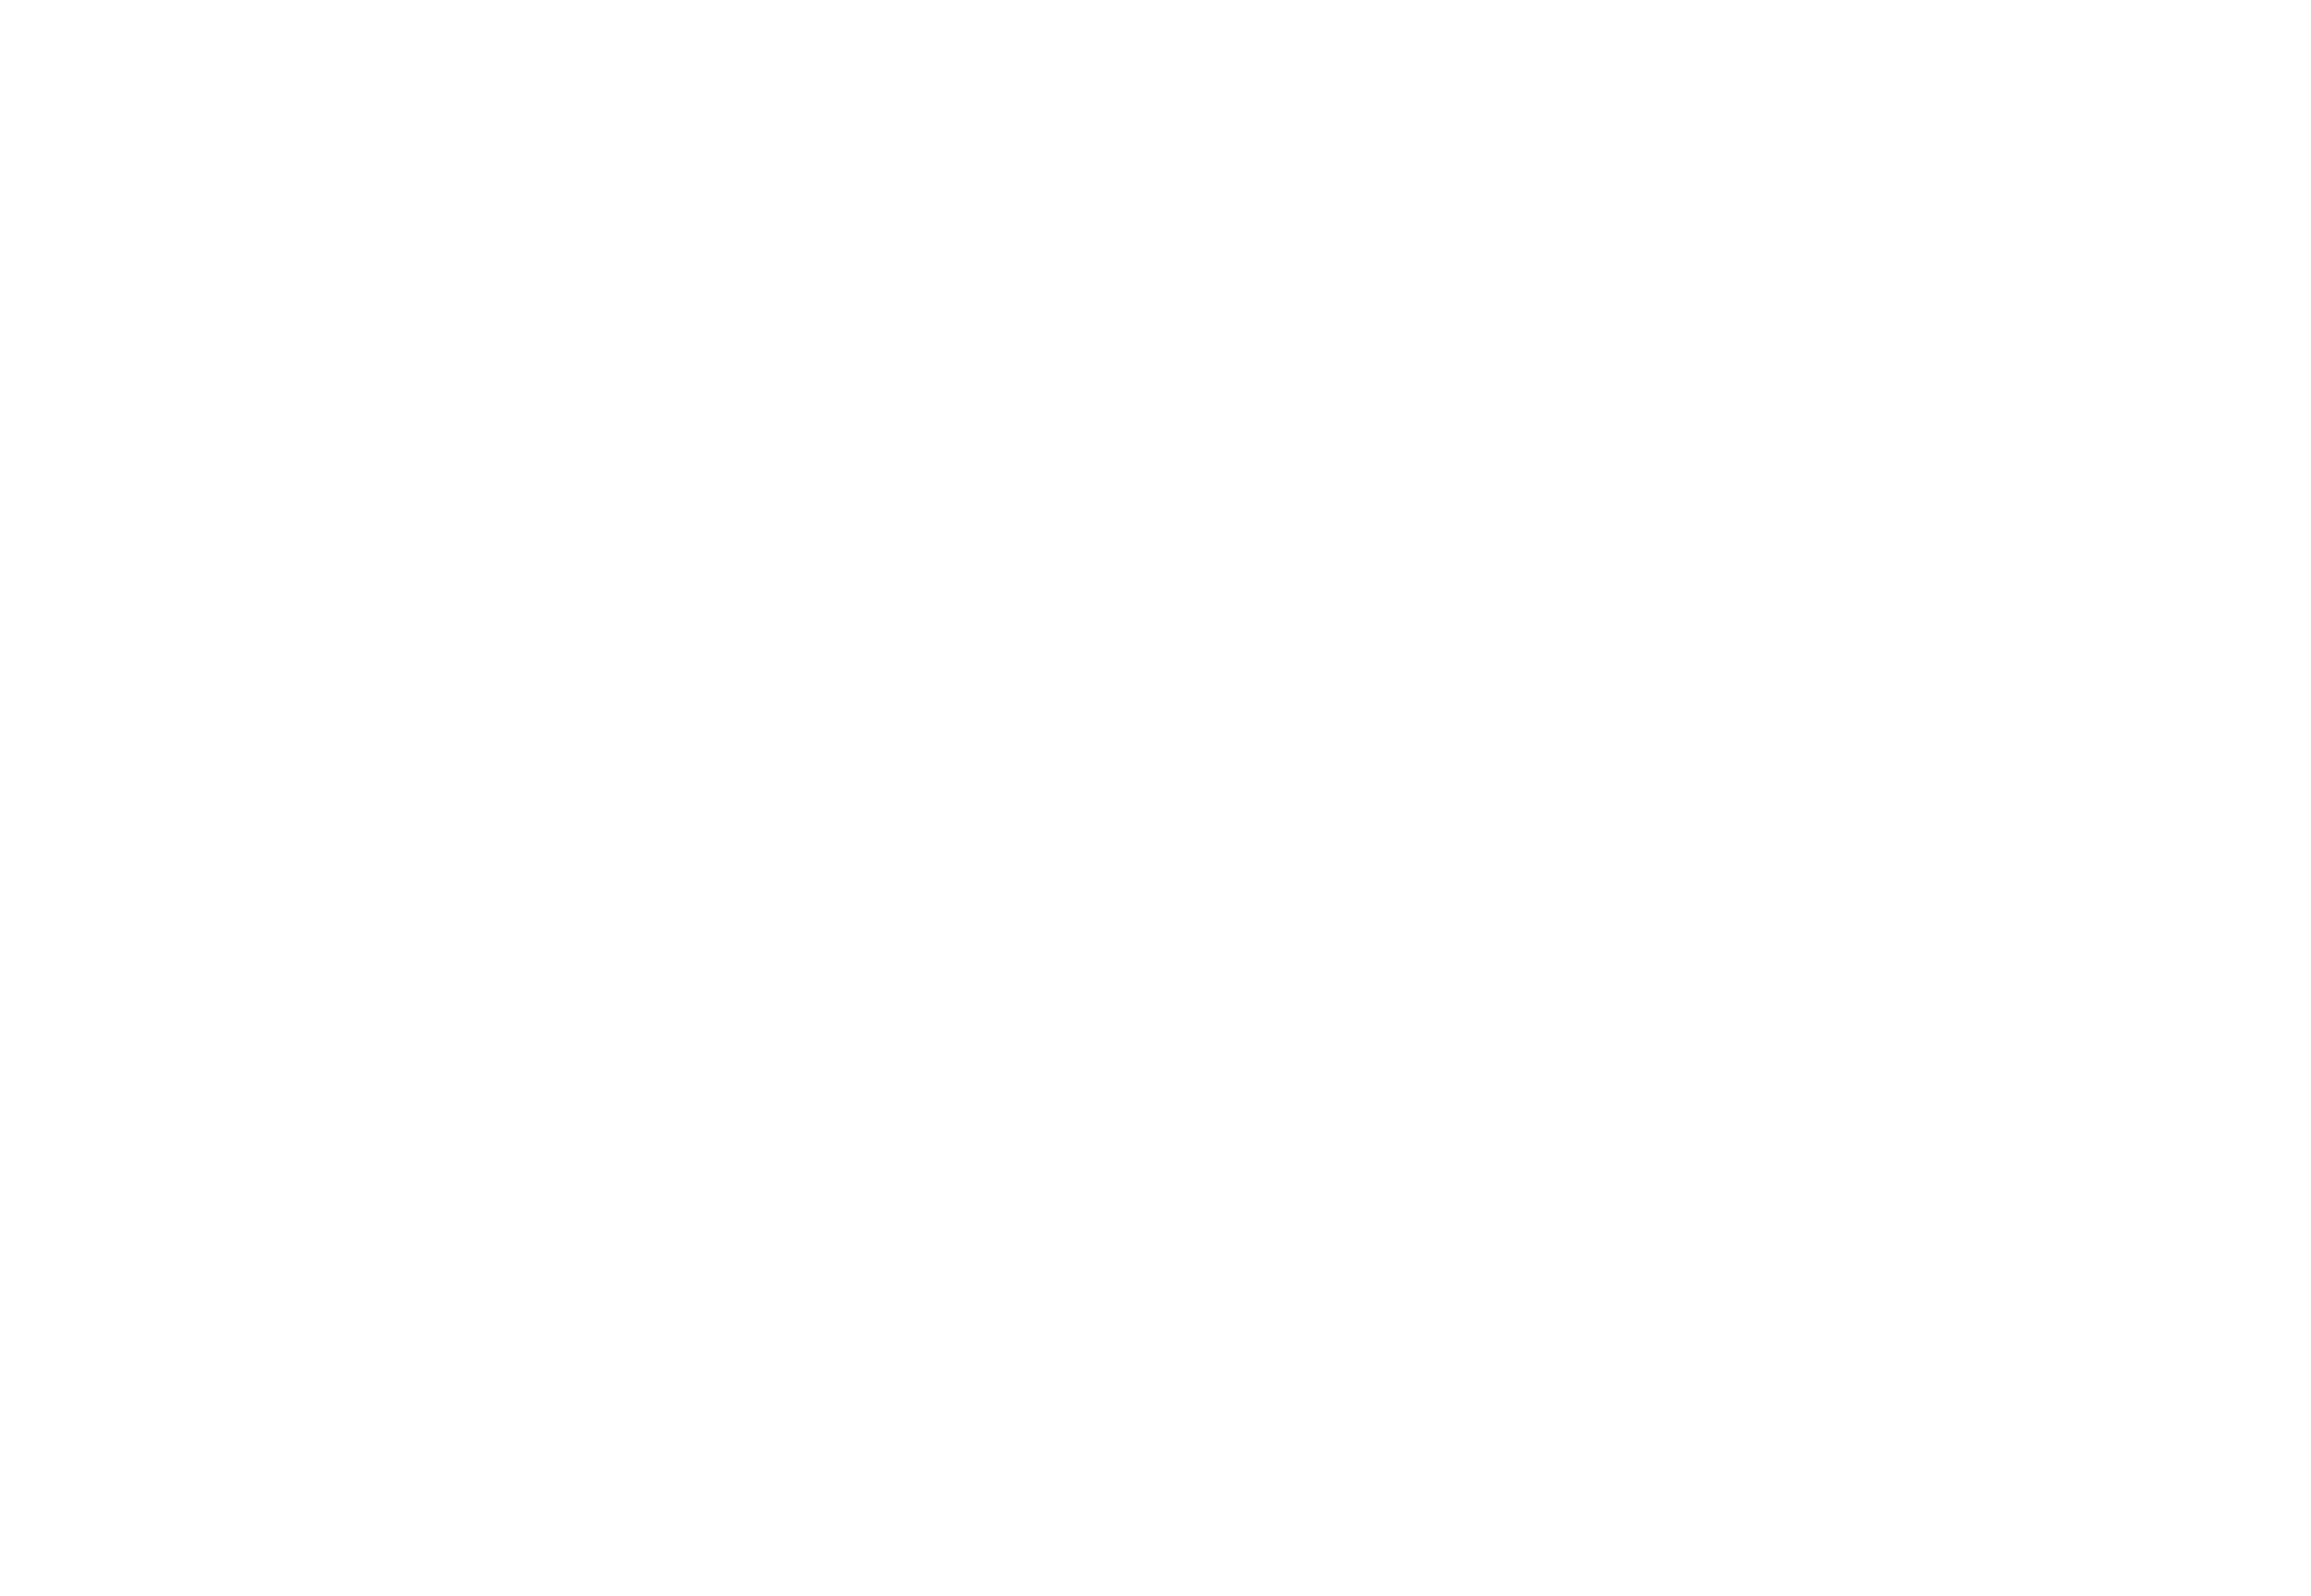

In [2]:
%matplotlib ipympl
PosterFig = Fig(size=(5.5*12,3.8*12), grid=(4, 4), width_ratios=[1, 2, 2, 2],
                height_ratios =[1, 2, 2, 2], fontsize=20)

In [3]:
ax_title = PosterFig.subplot(PosterFig.gs[0,:])

ax_title.text(0.5, 0.3, 'TITLE HERE', fontdict={'fontsize': 50})

Text(0.5, 0.3, 'TITLE HERE')

### TEXT BOX PLACE HOLDERS

In [4]:
# BACKGROUND BOX PLACEHOLDER
ax_background = PosterFig.subplot(PosterFig.gs[1, 0])
ax_background.set_title('BACKGROUND', fontdict={'fontsize': 40})

Text(0.5, 1.0, 'BACKGROUND')

In [5]:
# EXP OUTLINE PLACEHOLDER
ax_outline = PosterFig.subplot(PosterFig.gs[2:, 0])
ax_outline.set_title('EXP. OUTLINE', fontdict={'fontsize': 40})

Text(0.5, 1.0, 'EXP. OUTLINE')

In [6]:
# METHODOLOGY PLACEHOLDER
ax_meth = PosterFig.subplot(PosterFig.gs[1, 1])
ax_meth.set_title('METHODOLOGY', fontdict={'fontsize': 40})

Text(0.5, 1.0, 'METHODOLOGY')

### Combined cell plots Example Rat (Finn)

In [39]:
import itertools
def make_careg(animal):
    # Specify sessions to plot here
    # Note animal cannot be Rat698, doesn't work for her
    sessions = ['Habituation2', 'Training', 'Recall1', 'Recall1']
    sesh_types = ['tone_habituation', 'training', 'tone_recall', 'control_tone_recall']
    CS_types = ['CS+', 'CS+', 'CS+', 'CS-']
    keep = [['good', 'maybe_interneurons']]*len(sessions)
    trim = [None]*len(sessions)

    if animal == 'Finn':
        for idt in np.where([sesh == 'Training' for sesh in sessions])[0]:
            keep[idt] = None
            trim[idt] = 'bad_units'  

    # Assemble data
    careg = CaNeuronReg([MinianIO(basedir=sd.get_session_dir(animal, session)).trim_neurons(keep=ke, trim=tr) 
                         for session, ke, tr in zip(sessions, keep, trim)], alias=sessions)
    
    # Define colors to match CS types above
    CS_colors = [[1, 0.647, 0, 0.3] if cs_type == 'CS+' else [0, 1, 0, 0.3] for cs_type in CS_types]

    return careg, sessions, sesh_types, CS_types, CS_colors

In [33]:
def make_rastgroup_and_map(animal, sessions, sesh_types, CS_types, activity_type='C'):

    start_buffer, end_buffer = 10.0, 40.0
    rastgroups = []
    for sesh_name, sesh_type, CS_type in zip(sessions, sesh_types, CS_types):

        try:
            event_starts, event_ends = load_trace_events(sd.get_session_dir(animal, sesh_name), 
                                                         sesh_type, CS_type)
            rastgroups.append(RasterGroup(getattr(careg.get_session(sesh_name), activity_type), 
                                          careg.get_session(sesh_name).t['Timestamps'], 
                                          event_starts['Timestamp'], 
                                          event_ends['Timestamp'], 
                                          cell_ids=None, 
                                          start_buffer_sec=start_buffer, 
                                          end_buffer_sec=end_buffer))
        except ValueError: # Should catch any errors due to missing sessions for Rat698
            rastgroups.append(None)

    # Assemble maps
    map_sessions = ['Habituation2', 'Training','Recall1']
    msm = MultiSessionMap(pwmaps=[careg.load_pairwise_map(sesh1, sesh2) for sesh1, sesh2 in 
                           itertools.combinations(map_sessions, 2)], sesh_order=map_sessions)

    # Get full map for all sessions
    multi_sesh_map = msm.stepwise_reg(overwrite_indirect=True)
    
    # Load in event data
    events = [load_trace_events(sd.get_session_dir(animal, session), sesh_type, cs_type) 
              for session, sesh_type, cs_type in zip(sessions, sesh_types, CS_types)]
    
    return rastgroups, msm, multi_sesh_map, events

In [40]:
# Set up main example Rat: Finn
careg, sessions, sesh_types, CS_types, CS_colors = make_careg('Finn')
rastgroups, msm, multi_sesh_map, events = make_rastgroup_and_map('Finn', sessions, sesh_types, CS_types, 
                                                                 activity_type='C')

Eliminating timestamps from corrupted video8 in 13_16_31 folder.
Keeping 38506 good frames found in "good_frames_bool.npy" file
Eliminating timestamps from corrupted video18 in 12_49_22 folder.
Keeping 125447 good frames found in "good_frames_bool.npy" file
Eliminating timestamps from corrupted video0 in 12_37_59 folder.
Eliminating timestamps from corrupted video6 in 12_40_13 folder.
Keeping 42497 good frames found in "good_frames_bool.npy" file
Eliminating timestamps from corrupted video0 in 12_37_59 folder.
Eliminating timestamps from corrupted video6 in 12_40_13 folder.
Keeping 42497 good frames found in "good_frames_bool.npy" file


### SINGLE CELL RESPONSES

In [64]:
# Example neurons from Finn

# First get coactive neurons
coactive_bool = (multi_sesh_map > -1).sum(axis=1) >= 2
coactive_map = multi_sesh_map[coactive_bool]
ncoactive = coactive_map.shape[0]

map_use = coactive_map[sessions]
caneurons_use = [careg.get_session(sesh) for sesh in sessions]

good_neurons = [15, 24, 34]
_, ax = plot_paired_CS_PETH(caneurons_use, event_starts=[event[0] for event in events], 
                            event_ends=[event[1] for event in events], var_plot='C', 
                            neuron_inds=map_use.iloc[good_neurons,:].values.T, cs_types=CS_types, 
                            sesh_names=sesh_types, cs_color=CS_colors, plot_rast=True, cbar=False, 
                            cmap='viridis', rasterized=False, fig_or_gs_use=PosterFig.gs[2, 1])


In [ ]:
PosterFig.gs[2, 1].get

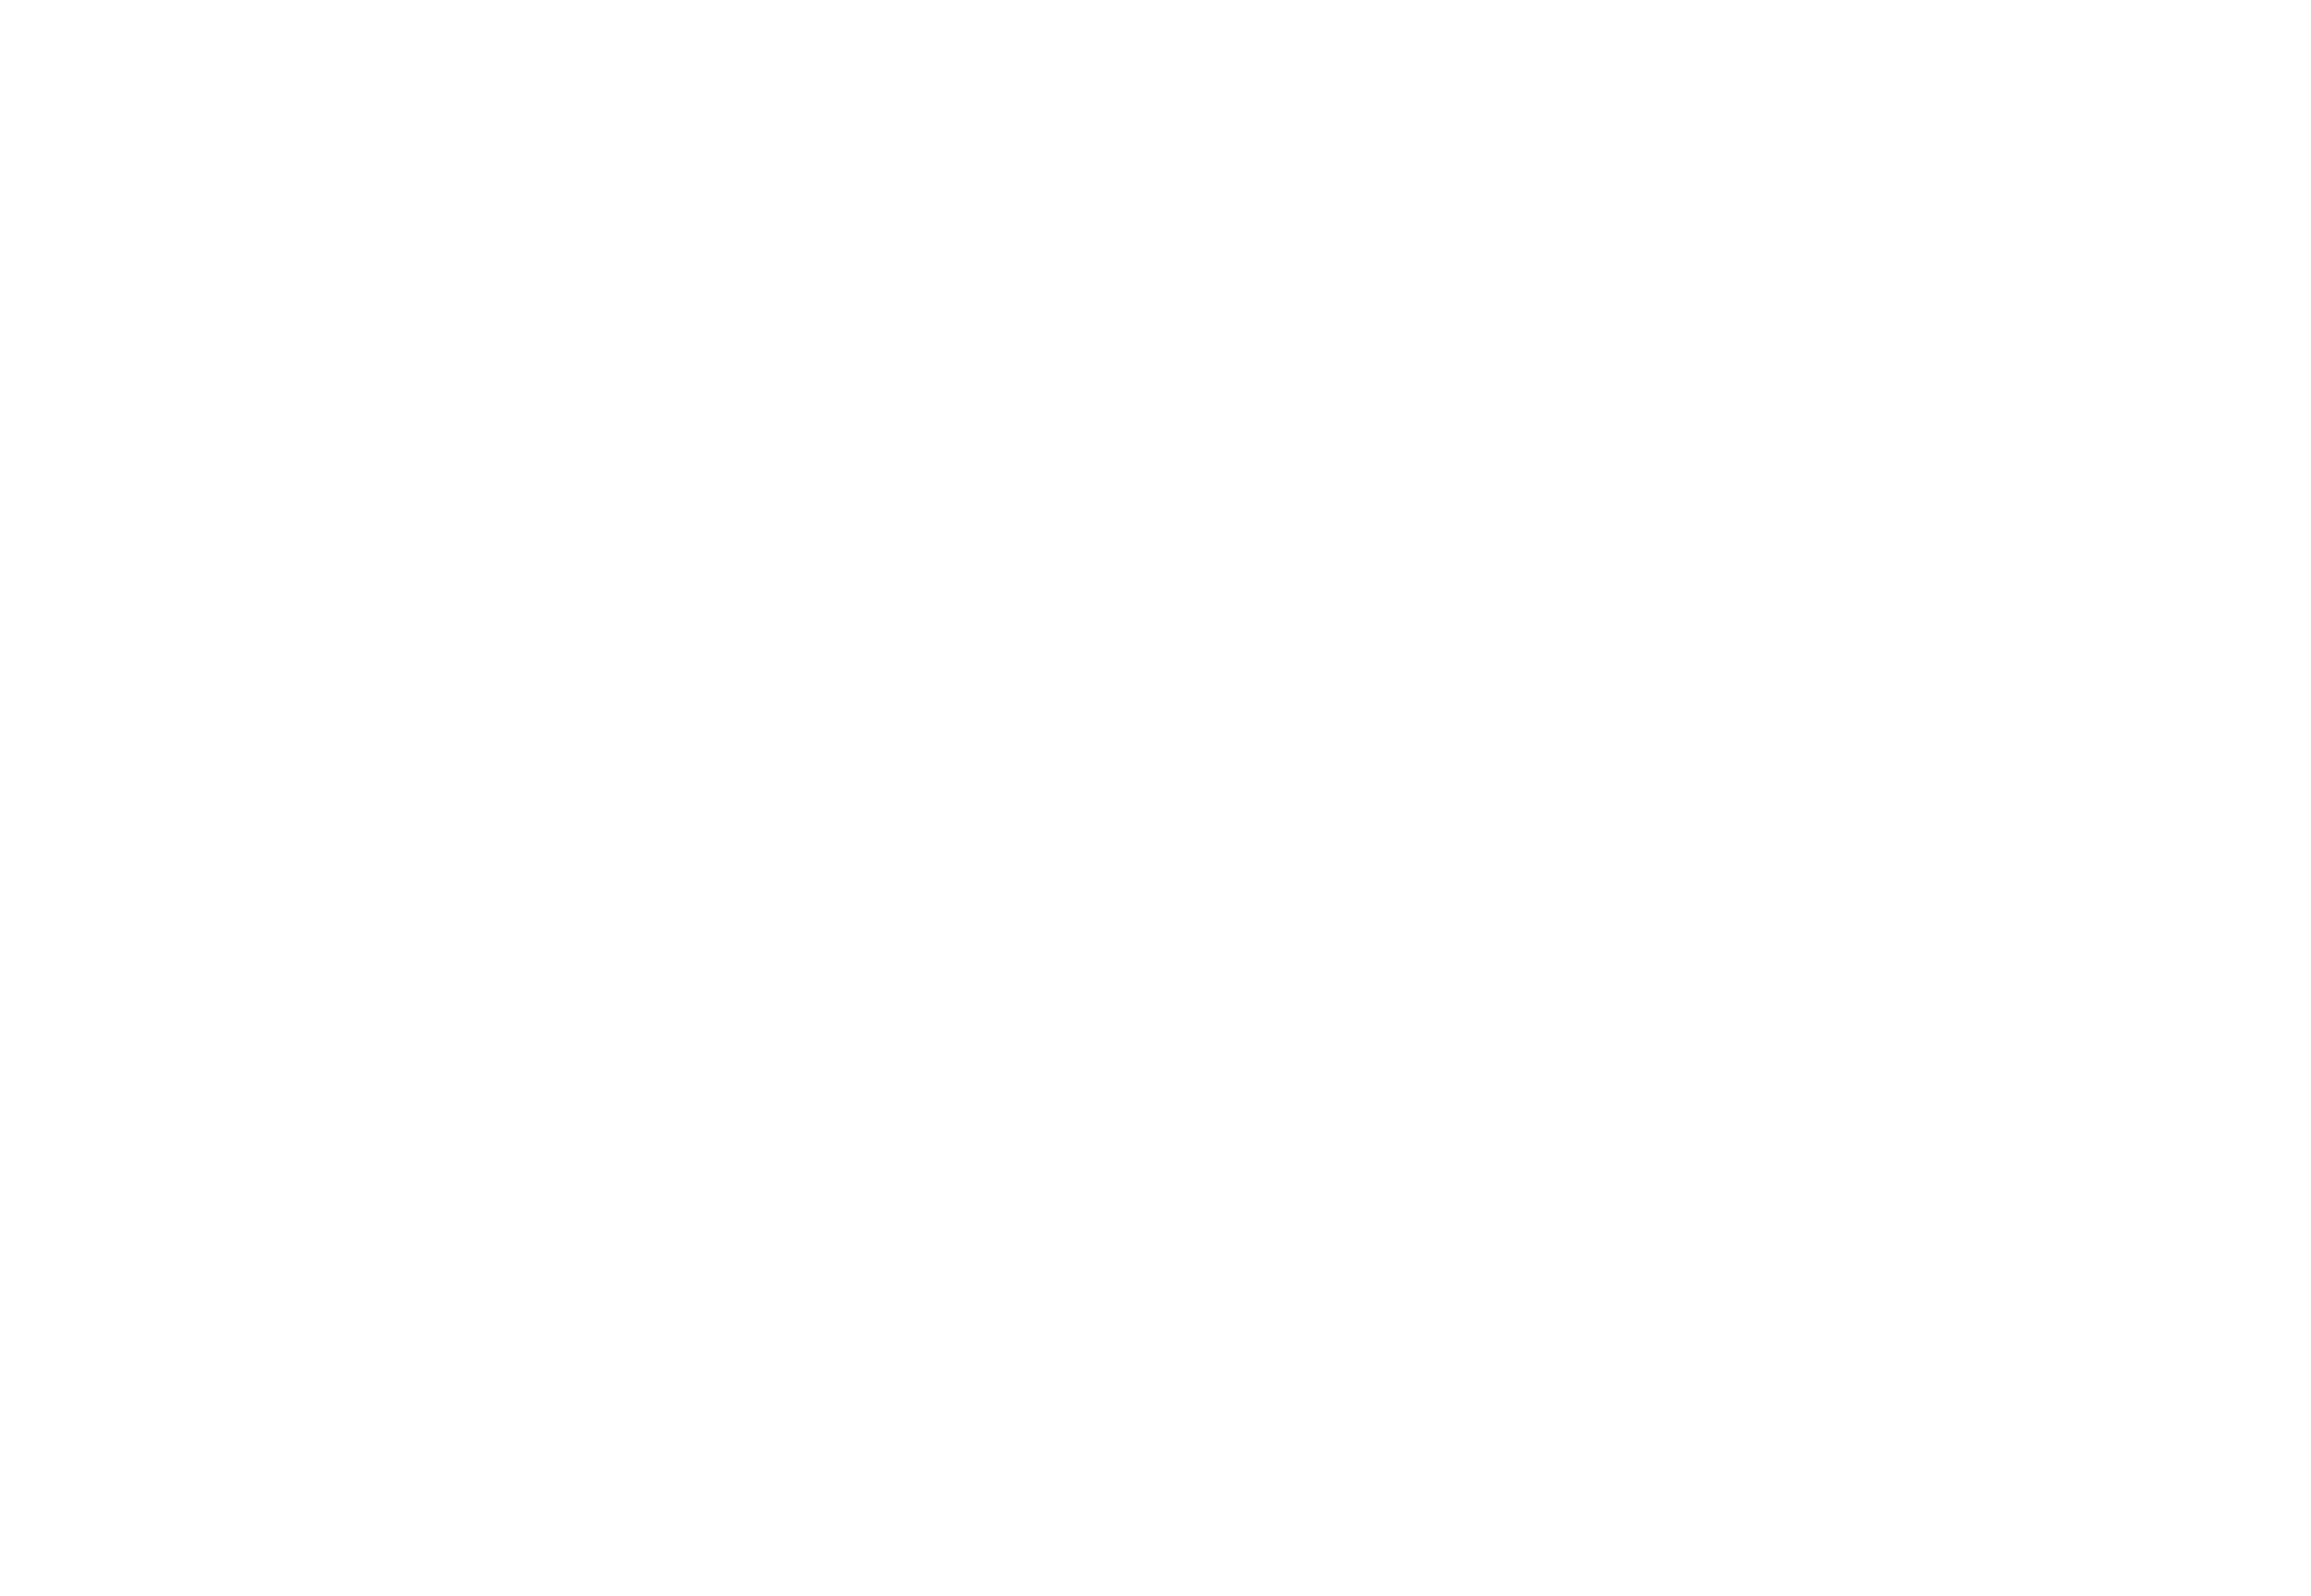

In [13]:
# Fig to hold extra potential Single cell responses!
PosterFig2 = Fig(num="Poster Fig alternative panels", size=(5.5*12,3.8*12), grid=(4, 4), 
                 width_ratios=[1, 2, 2, 2], height_ratios =[1, 2, 2, 2], fontsize=20)

In [14]:
ax_single_alt = PosterFig2.subplot2grid(PosterFig2.gs[2:, 1], grid=(6, 4))

### POPULATION CA IMAGING - Snake Plots

In [15]:
ax_snake = PosterFig.subplot2grid(PosterFig.gs[3, 1], grid=(2, 4), return_axes=True)
sort_ids = []  # keep track of how you sorted things
for a, rgroup, sesh_name, CStype in zip(ax_snake[0], rastgroups, sessions, CS_types):
    if rgroup is not None:
        ids = rgroup.snake_plot(sortby=sortby, ax=a, cbar=False, rasterized=True)
        sort_ids.append(ids)
        a.set_title(f"{sesh_name}: {CStype}", fontdict={'fontsize': 32})

/data/GitHub/NeuroPy/neuropy/plotting/ca_events.py:561: RuntimeWarning: invalid value encountered in true_divide
  sorted_mean_rast = sorted_mean_rast / sorted_mean_rast.max(axis=1)[:, None]


In [16]:
ax_reg = ax_snake[1]
map_use = msm.grab_map(['Habituation2', 'Recall1'], coactive_only=True)
cells_to_grab = map_use['Habituation2'].values  # Get cells active in this session

# Plot Habituation2 first with blue box around it
sort_id = rastgroups[0].cell_slice(map_use['Habituation2'].values).snake_plot(sortby="peak_time", ax=ax_reg[0], 
                                                                              cbar=False, rasterized=True)
ax_reg[0].set_title('Habituation2: CS+', fontdict={'fontsize': 32})
plt.setp(ax_reg[0].spines.values(), color='b', linewidth=4)
sns.despine(left=False, right=False, top=False, bottom=False, ax=ax_reg[0])

# Plot Recall1 CS+
rastgroups[2].cell_slice(map_use['Recall1'].values).snake_plot(sortby=sort_id, ax=ax_reg[2], 
                                                               cbar=False, rasterized=True)
ax_reg[2].set_title('Recall1: CS+', fontdict={'fontsize': 32})

# Plot Recall1 CS-
rastgroups[3].cell_slice(map_use['Recall1'].values).snake_plot(sortby=sort_id, ax=ax_reg[3], 
                                                               cbar=False, rasterized=True)
ax_reg[3].set_title('Recall1: CS-', fontdict={'fontsize': 32})

# Last fill in Training
map_use = msm.grab_map(['Habituation2', 'Training'], coactive_only=False).loc[cells_to_grab]
rastgroups[1].cell_slice(map_use['Training'].values).snake_plot(sortby=sort_id, ax=ax_reg[1], 
                                                               cbar=False, rasterized=True)
ax_reg[1].set_title('Training: CS+', fontdict={'fontsize': 32})



/data/GitHub/NeuroPy/neuropy/plotting/ca_events.py:544: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sortby == "peak_time" or sortby == "trough_time":
/data/GitHub/NeuroPy/neuropy/plotting/ca_events.py:544: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sortby == "peak_time" or sortby == "trough_time":
/data/GitHub/NeuroPy/neuropy/plotting/ca_events.py:47: RuntimeWarning: Mean of empty slice
  np.nanmean(self.raster, axis=0) if self.raster is not None else None
/data/GitHub/NeuroPy/neuropy/plotting/ca_events.py:561: RuntimeWarning: invalid value encountered in true_divide
  sorted_mean_rast = sorted_mean_rast / sorted_mean_rast.max(axis=1)[:, None]


Text(0.5, 1.0, 'Training: CS+')

### Combined cell plots all animals

In [17]:
ax_snake_all = PosterFig.subplot(PosterFig.gs[3, 2])

### SWR - PL coupling

In [18]:
ax_SWR = PosterFig.subplot(PosterFig.gs[1, 2])
ax_SWR.set_title('SWR-PL COUPLING', fontdict={'fontsize': 40})

Text(0.5, 1.0, 'SWR-PL COUPLING')

## Save Figure!

In [19]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')


<IPython.core.display.Javascript object>

In [20]:
 # Get notebook name
nb_full_path = os.path.join(os.getcwd(), nb_name)

In [21]:
PosterFig.savefig(Path('/home/nkinsky/Dropbox/UM/SfN/2022/Poster/SfN_Poster2022.pdf'), 
                 scriptname=nb_full_path)

meta NOT subset; don't know how to subset; dropped
